<a href="https://colab.research.google.com/github/tehutahu/PGGAN/blob/master/Kagiyama_Hina_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 使い方(Colaboratory自体が初めての人向け)
1. ↑のバーから「ランタイム」→「ランタイムのタイプを変更」→「ハードウェアアクセラレート」をGPUに
1. コードが書いてある部分を「セル」と呼びます。セルを選択し、セル左横の再生マークを押すか、Shift+Enter or Ctrl+Enterでセルが実行されます。
1. セルが実行されると、すぐ下にその実行結果が出ます(出ない物もあります)。実行が終了したかどうかは、再生マークが回っているか数字に変わっているかで分かります。
1. 上から順にこれを繰り返していってください。「生成」と書いてあるセクションからがメインです


### 練習用セル
以下のセルで実行を試してみて、結果の表示(OK)と実行が終了しているかを確認してください。  
何度実行しても大丈夫です

In [ ]:
print("OK")

OK


## 環境の用意
リポジトリのクローン、雛モデルのダウンロード

In [ ]:
%%bash
git clone https://github.com/tehutahu/PGGAN.git
cd ./PGGAN/
pip install -r requirements.txt

mkdir -p ./output_networks/hina
curl -sc /tmp/cookie "https://drive.google.com/uc?export=download&id=1OH7FnhlsUfWTzfaoHGGWhIqFOeL3aaId" > /dev/null
CODE="$(awk '/_warning_/ {print $NF}' /tmp/cookie)"  
curl -Lb /tmp/cookie "https://drive.google.com/uc?export=download&confirm=${CODE}&id=1OH7FnhlsUfWTzfaoHGGWhIqFOeL3aaId" -o weights.zip
unzip weights.zip -d ./output_networks/hina/
rm weights.zip

Archive:  weights.zip
  inflating: ./output_networks/hina/s.zip  


fatal: destination path 'PGGAN' already exists and is not an empty directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    918      0 --:--:-- --:--:-- --:--:--   916
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  245M    0  245M    0     0  60.7M      0 --:--:--  0:00:04 --:--:-- 83.9M
replace ./output_networks/hina/hina_losses.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace ./output_networks/hina/hina_refVectors.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [ ]:
%cd ./PGGAN

/content/PGGAN


## 準備
モデルの組み立て

In [ ]:
import importlib
import os
import json
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from copy import deepcopy
from google.colab import files

from models.gan_visualizer import GANVisualizer
from models.utils.utils import loadmodule, getLastCheckPoint, getVal, \
    getNameAndPackage, parse_state_name
  
name = "hina"
module = "PGAN"
scale = None
iter = None
dir = "output_networks"
visualisation = importlib.import_module("visualization.np_visualizer")

checkPointDir = os.path.join(dir, name)
checkpointData = getLastCheckPoint(checkPointDir,
                                    name,
                                    scale=scale,
                                    iter=iter)
if checkpointData is None:
    raise FileNotFoundError(
        "Not checkpoint found for model " + name + " at directory " + dir)

modelConfig, pathModel, _ = checkpointData
if scale is None:
    _, scale, _ = parse_state_name(pathModel)

    pathLoss = os.path.join(checkPointDir, name + "_losses.pkl")
pathOut = os.path.splitext(pathModel)[0] + "_fullavg.jpg"

packageStr, modelTypeStr = getNameAndPackage(module)
modelType = loadmodule(packageStr, modelTypeStr)
exportMask = module in ["PPGAN"]

visualizer = GANVisualizer(
    pathModel, modelConfig, modelType, visualisation)

Average network found !


**"Average network found ! "**が出力されていたら準備完了です

# 生成 (Generator)
実行の度に乱数から画像群を生成

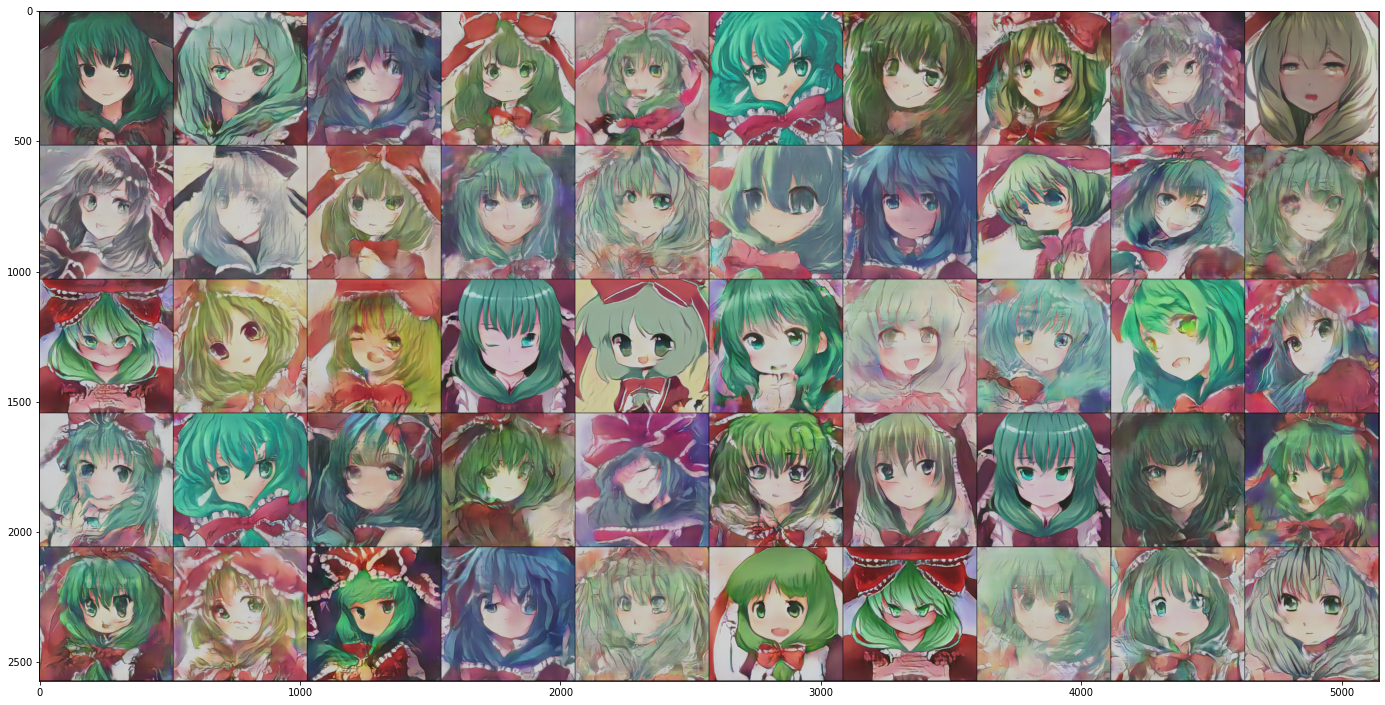

In [ ]:
#@title 生成枚数指定。多すぎると描画に時間がかかります
batch_size = 50 # @param {type:"slider", min:1, max:100, step:1}
is_download = False #@param {type:"boolean"}
file_name = "hina_grid.jpg" #@param {type:"string"}

z, _ = visualizer.model.buildNoiseData(batch_size)
img = visualizer.model.test(z, getAvG=True)
grid = torchvision.utils.make_grid(img, nrow=10, normalize=True).numpy().transpose(1,2,0)
plt.subplots(figsize=(24,24))
plt.imshow(grid)

if is_download:
  Image.fromarray((grid*255).astype(np.uint8)).save(file_name)
  files.download(file_name)

##上から1枚を選んで表示と保存

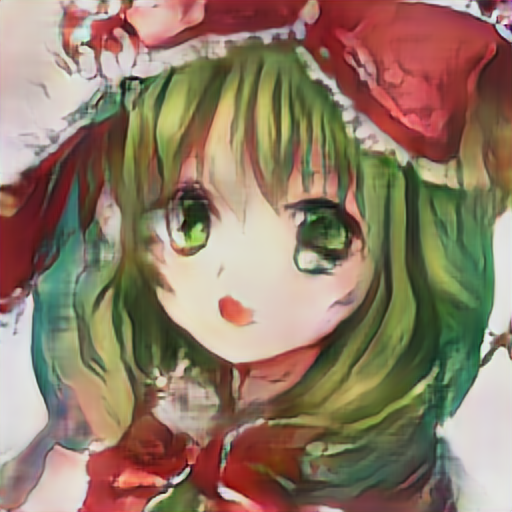

In [ ]:
#@title xが右方向、yが下方向、それぞれ座標で指定
x = 8 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
y = 1 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
is_download = False #@param {type:"boolean"}
file_name = "hina.jpg" #@param {type:"string"}
rand_name = "hina_DNA.npy" #@param {type:"string"}

try:
  fz = deepcopy(z[(y-1)*10+(x-1)].unsqueeze(0))
except IndexError as e:
  print("存在しません。y入力を見直してください")
  sys.exit(0)

fav = visualizer.model.test(fz, getAvG=True)
fav = torchvision.utils.make_grid(fav, nrow=1, normalize=True).numpy().transpose(1,2,0)
fav = Image.fromarray((fav*255).astype(np.uint8))

if is_download:
  np.save(rand_name, fz.cpu().numpy())
  fav.save(file_name)
  files.download(file_name)
  files.download(rand_name)
fav

## 中間画像生成 (Interpolate)
2枚の画像の中間にあたる特徴を持った画像を生成

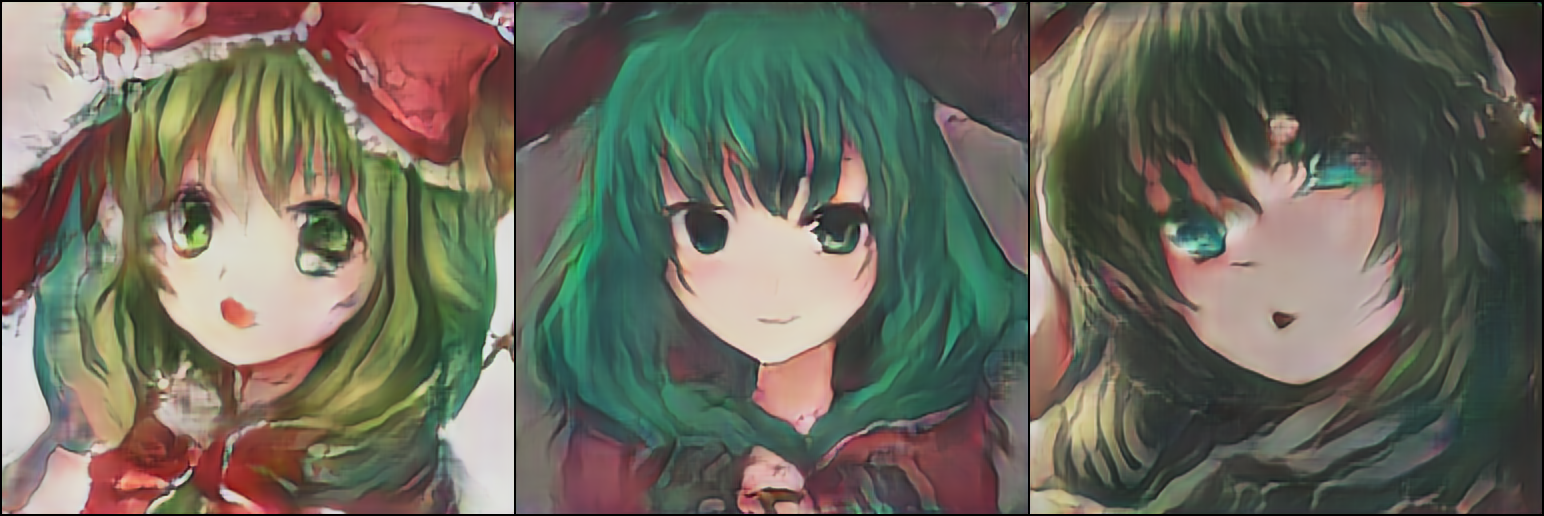

In [ ]:
#@title tは中間位置の割合。0に近いほど1枚目の画像に近い
t = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
x1 = 8 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
y1 = 1 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
x2 = 1 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
y2 = 1 #@param [1,2,3,4,5,6,7,8,9,10] {type:"raw"}
is_download = False #@param {type:"boolean"}
file_name = "hina_interpolate.jpg" #@param {type:"string"}

try:
  fz1 = deepcopy(z[(y1-1)*10+(x1-1)].unsqueeze(0))
  fz2 = deepcopy(z[(y2-1)*10+(x2-1)].unsqueeze(0))
except IndexError as e:
  print("存在しません。y入力を見直してください")
  sys.exit(0)

iz = (1 - t) * fz1 + t * fz2
gen1 = visualizer.model.test(fz1, getAvG=True)
gen2 = visualizer.model.test(fz2, getAvG=True)
inter = visualizer.model.test(iz, getAvG=True)
inter = torchvision.utils.make_grid(torch.cat([gen1, gen2, inter]), nrow=3, normalize=True).numpy().transpose(1,2,0)
inter = Image.fromarray((inter*255).astype(np.uint8))

if is_download:
  inter.save(file_name)
  files.download(file_name)
inter

## モーフィング
中間生成の動画版

In [ ]:
#@title 
import cv2
import base64
import io
from IPython.display import HTML

fps = 8 #@param {type:"slider", min:5, max:30, step:1}
is_download = False #@param {type:"boolean"}
file_name = "hina_mofing.mp4" #@param {type:"string"}

pathOut = os.path.splitext(pathModel)[0] + "_interpolations"
os.makedirs(pathOut, exist_ok=True)
interpolationVectors = torch.cat([fz1, fz2])

nImgs = interpolationVectors.size(0)
for img in range(nImgs):
    indexNext = (img + 1) % nImgs
    path = os.path.join(pathOut, str(img) + "_" + str(indexNext))
    if not os.path.isdir(path):
        os.mkdir(path)
    path = os.path.join(path, "")
    visualizer.saveInterpolation(
        100, interpolationVectors[img],
        interpolationVectors[indexNext], path)

# make video
img_dir = "./output_networks/hina/hina_s7_i96000_interpolations/0_1/"
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(file_name, fourcc, fps, (512,512))

frames = []
for fname in sorted(os.listdir(img_dir)):
    fpath = os.path.join(img_dir, fname)
    frame = cv2.imread(fpath)
    out.write(frame)
    frames.append(frame[:,:,[2,1,0]])
out.release()

if is_download:
  files.download(file_name)

# play video
if os.path.isfile("./out.webm"):
  os.remove("./out.webm")
!ffmpeg -i ./*.mp4 -vcodec vp9 ./out.webm -loglevel fatal

def play(file_path):
    video = io.open(file_path, 'r+b').read()
    encoded = base64.b64encode(video)
    return(HTML(data='''<video width="320" height="240" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

play('./out.webm')

# 生成(旧)

In [ ]:
import matplotlib.pyplot as plt
 
!python eval.py visualization -n hina -m PGAN --np_vis
gen = plt.imread("/content/PGGAN/output_networks/hina/hina_s7_i96000_fullavg.jpg")
wall = int(gen.shape[0] / (gen.shape[0] / gen.shape[1]))
_, axes = plt.subplots(2,int(gen.shape[0] / gen.shape[1] / 2), figsize=(16,16))
for i, ax in enumerate(axes.flatten()):
  ax.imshow(gen[i*wall:(i+1)*wall,:,:])
  ax.set_axis_off()
plt.show()

In [ ]:
#@title エリアが"Z"字順、xが右方向、yが下方向、それぞれ(1,2,3,4)から選択
from google.colab import files
from PIL import Image
resolution = 512

area = 1 #@param [1,2,3,4] {type:"raw"}
x = 4 #@param [1,2,3,4] {type:"raw"}
y = 1 #@param [1,2,3,4] {type:"raw"}
is_download = False #@param {type:"boolean"}
file_name = "hina.jpg" #@param {type:"string"}

img = Image.fromarray(gen[
                          resolution*((area-1)*4+y-1):resolution*((area-1)*4+y), 
                          resolution*(x-1):resolution*x,
                          :]
                      )
if is_download:
  img.save(file_name)
  files.download(file_name)
img

In [ ]:
import numpy as np

def get_fav(gen, point, resolution, row=8, is_True=True):
  grid_x = int(np.ceil(len(point)/row)*resolution)
  grid_y = min(resolution*row, len(point)*resolution)
  grid = np.zeros((grid_x, grid_y, 3), dtype=np.int)

  for i, (area, x, y) in enumerate(point):
    write_x = int(np.floor(i / row))
    write_y = i % row
    grid[write_x*resolution:(write_x+1)*resolution, write_y*resolution:(write_y+1)*resolution, :] = \
      gen[resolution*y:resolution*(y+1),resolution*(area*row+x):resolution*(area*row+x+1),:]
  plt.figure(figsize=(14,14))
  plt.imshow(grid)
  plt.show()
  return grid

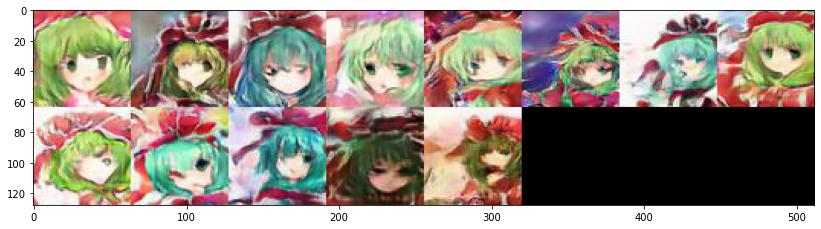

array([[[220,  85,  91],
        [210,  90,  91],
        [197,  96,  88],
        ...,
        [  6,  43,  35],
        [ 37,  81,  68],
        [ 74, 122, 106]],

       [[208, 100,  97],
        [211,  97,  96],
        [216,  92,  92],
        ...,
        [112, 128, 117],
        [117, 140, 124],
        [147, 174, 155]],

       [[189, 101,  91],
        [206,  92,  91],
        [226,  81,  88],
        ...,
        [198, 175, 161],
        [185, 167, 147],
        [210, 192, 170]],

       ...,

       [[183,  74,  93],
        [212, 115, 132],
        [251, 179, 190],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[221,  90, 121],
        [204,  90, 116],
        [213, 129, 145],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 127, 163],
        [211,  86, 118],
        [186,  94, 115],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
favs = [[2,4,0],
        [3,7,6],
        [1,7,0],
        [1,7,7],
        [0,1,5],
        [2,3,3],
        [0,2,2],
        [0,7,4],[2,1,7],[2,0,3],
        [1,3,7],[3,4,1],[3,5,3]
        ]
fav_img = get_fav(gen, favs, 64, is_save=True)